In [837]:
import numpy as np
import matplotlib.pyplot as plt
import keras

In [838]:
# Load MNIST dataset for training

try:
    from keras.datasets import mnist
    mnist_available = True
except ImportError:
    mnist_available = False
    print("keras not found. Install with: pip install keras")

if not mnist_available:
    raise ImportError("keras is required. Install with: pip install keras")

# Load MNIST
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Normalize to [0, 1] and flatten to vectors
X_train = X_train.astype('float32') / 255.0
X_train_flat = X_train.reshape(X_train.shape[0], -1)

# For faster prototyping, use a subset (e.g., first 5000 samples)
n_samples = 5000
training_data = X_train_flat[:n_samples]

print(f"MNIST data shape: {X_train.shape}")
print(f"Using {n_samples} samples for training")
print(f"Each digit flattened to {training_data.shape[1]} dimensions")


MNIST data shape: (60000, 28, 28)
Using 5000 samples for training
Each digit flattened to 784 dimensions


In [839]:
class Neuron:
    """Lightweight neuron wrapper that delegates storage to the RBM arrays.
    Keeps per-neuron API (state, sample_state) for educational parity with the
    original BoltzmannMachine implementation while permitting efficient
    vectorized RBM computations under the hood.
    """
    def __init__(self, index, layer, rbm):
        # layer: 'v' for visible, 'h' for hidden
        self.index = index
        self.layer = layer
        self.rbm = rbm

    @property
    def state(self):
        if self.layer == 'v':
            return float(self.rbm.v[self.index])
        return float(self.rbm.h[self.index])

    @state.setter
    def state(self, value):
        if self.layer == 'v':
            self.rbm.v[self.index] = float(value)
        else:
            self.rbm.h[self.index] = float(value)

    def activate(self, x):
        # reuse RBM's sigmoid (with clipping handled there)
        return self.rbm.sigmoid(x)

    def sample_state(self, input_sum):
        p = self.activate(input_sum)
        s = 1.0 if np.random.rand() < p else 0.0
        self.state = s
        return s

In [840]:
class RBM:
    """Restricted Boltzmann Machine that keeps per-unit `Neuron` objects
    for compatibility/education while performing vectorized operations.
    """
    def __init__(self, n_visible, n_hidden, learning_rate=0.01):
        self.n_visible = n_visible
        self.n_hidden = n_hidden
        self.learning_rate = learning_rate

        # Visible-to-hidden weight matrix (n_visible x n_hidden)
        self.W = np.random.normal(0, 0.01, (n_visible, n_hidden))

        # Separate biases
        self.v_bias = np.zeros(n_visible)
        self.h_bias = np.zeros(n_hidden)

        # State vectors (kept as numpy arrays for vectorized ops)
        self.v = np.zeros(n_visible, dtype=float)
        self.h = np.zeros(n_hidden, dtype=float)

        # Create neuron wrappers in the same ordering as original BM
        self.neurons = []
        for i in range(n_visible):
            self.neurons.append(Neuron(i, 'v', self))
        for j in range(n_hidden):
            self.neurons.append(Neuron(j, 'h', self))

    def sigmoid(self, x):
        # clipping helps numerical stability for extreme inputs
        return 1.0 / (1.0 + np.exp(-np.clip(x, -500, 500)))

    def sample_hidden(self, v):
        """Return hidden probabilities and sampled states given visible v.
        Also update the hidden neuron wrappers' states.
        """
        h_act = np.dot(v, self.W) + self.h_bias
        h_prob = self.sigmoid(h_act)
        h_sample = (np.random.rand(self.n_hidden) < h_prob).astype(float)

        # sync into rbm.h and neuron wrappers
        self.h[:] = h_sample
        for j in range(self.n_hidden):
            # neuron index in list: n_visible + j
            self.neurons[self.n_visible + j].state = h_sample[j]

        return h_prob, h_sample

    def sample_visible(self, h):
        """Return visible probabilities and sampled states given hidden h.
        Also update visible neuron wrappers' states.
        """
        v_act = np.dot(h, self.W.T) + self.v_bias
        v_prob = self.sigmoid(v_act)
        v_sample = (np.random.rand(self.n_visible) < v_prob).astype(float)

        # sync into rbm.v and neuron wrappers
        self.v[:] = v_sample
        for i in range(self.n_visible):
            self.neurons[i].state = v_sample[i]

        return v_prob, v_sample

    def contrastive_divergence(self, v_data, k=1):
        """CD-k update for a single data vector v_data.
        This keeps the per-neuron API but uses vectorized gradients.
        """
        # Ensure v_data is float array
        v0 = np.array(v_data, dtype=float)

        # Positive phase: clamp visible units to data and compute hidden probs
        self.v[:] = v0
        for i in range(self.n_visible):
            self.neurons[i].state = v0[i]

        h0_prob, h0_sample = self.sample_hidden(v0)

        # Negative phase: start from sampled hidden units
        h = h0_sample.copy()
        for _ in range(k):
            v_prob, v_sample = self.sample_visible(h)
            h_prob, h = self.sample_hidden(v_sample)

        # Compute gradients (outer products)
        pos_grad = np.outer(v0, h0_prob)
        neg_grad = np.outer(v_prob, h_prob)

        # Parameter updates
        self.W += self.learning_rate * (pos_grad - neg_grad)
        self.v_bias += self.learning_rate * (v0 - v_prob)
        self.h_bias += self.learning_rate * (h0_prob - h_prob)

    def gibbs_sample(self, steps=50):
        """Generate one visible sample by alternating Gibbs updates.
        This initializes randomly and updates both the arrays and neuron wrappers.
        """
        # Random initial visible state
        self.v[:] = (np.random.rand(self.n_visible) < 0.5).astype(float)
        for i in range(self.n_visible):
            self.neurons[i].state = self.v[i]

        for _ in range(steps):
            _, h = self.sample_hidden(self.v)
            _, v = self.sample_visible(h)

        return self.v.copy()


In [841]:
# Instantiate RBM for MNIST (784 visible units for 28x28 images)

n_visible = training_data.shape[1]  # 784 for MNIST
n_hidden = 128  # 128 hidden units

rbm = RBM(n_visible=n_visible, n_hidden=n_hidden, learning_rate=0.01)

n_epochs = 500
n_samples_per_epoch = min(1000, len(training_data))

for epoch in range(n_epochs):
    # Shuffle data each epoch
    indices = np.random.permutation(len(training_data))
    
    for idx in indices[:n_samples_per_epoch]:
        data = training_data[idx]
        rbm.contrastive_divergence(data, k=1)

    print(f"Epoch {epoch+1}/{n_epochs} complete.")


Epoch 1/500 complete.
Epoch 2/500 complete.
Epoch 2/500 complete.
Epoch 3/500 complete.
Epoch 3/500 complete.
Epoch 4/500 complete.
Epoch 4/500 complete.
Epoch 5/500 complete.
Epoch 5/500 complete.
Epoch 6/500 complete.
Epoch 6/500 complete.
Epoch 7/500 complete.
Epoch 7/500 complete.
Epoch 8/500 complete.
Epoch 8/500 complete.
Epoch 9/500 complete.
Epoch 9/500 complete.
Epoch 10/500 complete.
Epoch 10/500 complete.
Epoch 11/500 complete.
Epoch 11/500 complete.
Epoch 12/500 complete.
Epoch 12/500 complete.
Epoch 13/500 complete.
Epoch 13/500 complete.
Epoch 14/500 complete.
Epoch 14/500 complete.
Epoch 15/500 complete.
Epoch 15/500 complete.
Epoch 16/500 complete.
Epoch 16/500 complete.
Epoch 17/500 complete.
Epoch 17/500 complete.
Epoch 18/500 complete.
Epoch 18/500 complete.
Epoch 19/500 complete.
Epoch 19/500 complete.
Epoch 20/500 complete.
Epoch 20/500 complete.
Epoch 21/500 complete.
Epoch 21/500 complete.
Epoch 22/500 complete.
Epoch 22/500 complete.
Epoch 23/500 complete.
Epoch

In [842]:
def sample_from_rbm(rbm, steps=500):
    # Generate a sample using RBM.gibbs_sample
    v = rbm.gibbs_sample(steps=steps)
    return v


In [843]:
sample = sample_from_rbm(rbm)
sample_img = sample.reshape(28, 28)


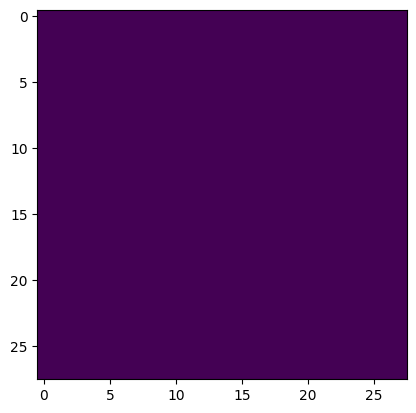

In [844]:
plt.imshow(sample_img)

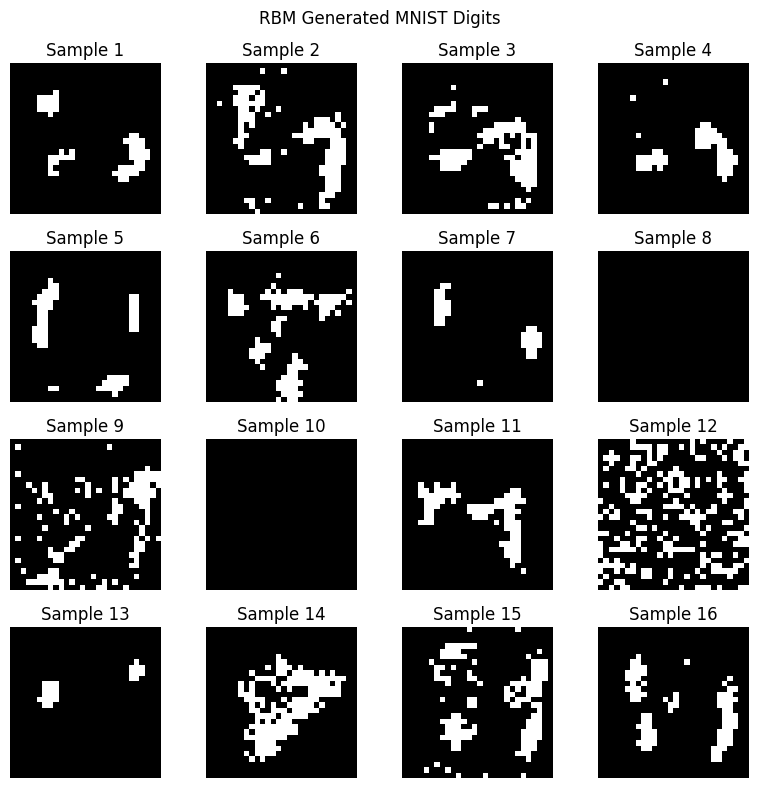

In [845]:
# Generate multiple samples and display them in a grid
n_samples_to_show = 16

fig, axes = plt.subplots(4, 4, figsize=(8, 8))
axes = axes.flatten()

for i in range(n_samples_to_show):
    sample = sample_from_rbm(rbm, steps=100)
    sample_img = sample.reshape(28, 28)
    
    axes[i].imshow(sample_img, cmap='gray', interpolation='nearest')
    axes[i].axis('off')
    axes[i].set_title(f'Sample {i+1}')

plt.suptitle('RBM Generated MNIST Digits')
plt.tight_layout()
plt.show()
